In [ ]:
import sys
sys.path.append('..')
from Simulation.helper_functions import calculate_DGv3, minimize_mol, calculate_entropy, get_dihedrals_by_name, kjmol_to_prop, get_cluster_asignments_ordered, mol_to_traj
from Simulation.helper_functions import SOLVENT_DICT as solvent_dict
from Simulation.helper_functions import MODEL_PATH
import matplotlib.pyplot as plt
from matplotlib import cm
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

### Function Definitions

In [3]:
kbt = 2.479

In [4]:
def get_mol(smiles, num_confs=1024):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    if num_confs > 0:
        AllChem.EmbedMultipleConfs(
            mol,
            numConfs=num_confs,
            randomSeed=42,
            useExpTorsionAnglePrefs=False,
            numThreads=int(8),
        )
    return mol

import mdtraj
from typing import DefaultDict
import sys
sys.path.append("../")
from Simulation.helper_functions import get_cluster_asignments_ordered, get_dihedrals_by_name, in_kjmol, calculate_entropy
from analysis import get_xyz
import tqdm
torsion_dict ={0:[('C7','C6','C5','N1'),('C5','N1','C4','C3')],
               1:[('C7','C6','C5','N1'),('C5','N1','C4','C3')],
               2:[('C1','C10','N1','H8'),('C13','C12','C11','O2')],
               3:[('C5','C6','N1','C7'),('C9','C8','C7','O2')],
               4:[('C5','C6','N1','C7'),('C9','C8','C7','O2')],}

def get_xyz_and_plot(ax,traj,idx,lims=5,set_max=0,levels=10,legend=True,colors="Blues_r"):

    indices = torsion_dict[idx]
    ref_dh1 = get_dihedrals_by_name(traj, *indices[0]).flatten() + np.pi
    ref_dh2 = get_dihedrals_by_name(traj, *indices[1]).flatten() + np.pi
    x,y,kjz = get_xyz(ref_dh1,ref_dh2,50,bins=np.linspace(0,2*np.pi,50))

    if set_max:
        kjz[kjz>=set_max] = set_max

    if idx in [3,4]:
        selection = (x<5) & (x>1)
    else:
        selection = (x<3) & (x>1)

    min_1 = np.min(kjz.T[selection,:])
    min_2 = np.min(kjz.T[~selection,:])

    ret = ax.contourf(x,y,kjz,levels=levels,cmap=colors,vmax=lims)
    if legend:
        plt.colorbar(ret,ax=ax,orientation="horizontal",label="Free Energy [kJ/mol]")
    
    return min_1-min_2

def plot_minimized_pos_and_energies(ax,traj,energies,idx,lims=5,zorder=0):
    indices = torsion_dict[idx]
    energies = energies - np.min(energies)
    ref_dh1 = get_dihedrals_by_name(traj, *indices[0]).flatten() + np.pi
    ref_dh2 = get_dihedrals_by_name(traj, *indices[1]).flatten() + np.pi

    selection = (ref_dh1<5) & (ref_dh1>1)
    min_1 = np.min(energies[selection])
    min_2 = np.min(energies[~selection])

    ref_dh1 = ref_dh1[energies<lims]
    ref_dh2 = ref_dh2[energies<lims]
    energies = energies[energies<lims]

    sorted_energies = np.argsort(energies)[::-1]
    ref_dh1 = ref_dh1[sorted_energies]
    ref_dh2 = ref_dh2[sorted_energies]
    energies = energies[sorted_energies]
    if lims == np.inf:
        colors = "Greys_r"
    else:
        colors = "Greys_r"
    ax.scatter(ref_dh1,ref_dh2,c=energies,cmap=colors,vmax=lims,zorder=zorder,marker="o",edgecolors="k",linewidths=0.5)
    return min_1-min_2

In [ ]:
conformational_smiles = np.loadtxt("../Simulation/simulation_smiles/conformational_ensemble_smiles.txt", dtype=str,comments=None)
model_path=MODEL_PATH

### Run minimisation

In [6]:
smiles = conformational_smiles[0]
mol = get_mol(smiles, num_confs=512)
out = minimize_mol(Chem.Mol(mol),"tip3p",model_path,solvent_dict,return_traj=True,return_gnn_sim=True,strides=16,cache="/tmp/example.cache")

Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Platform:  GPU  ready
Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Platform:  GPU  ready
Platform:  GPU  ready
Platform:  GPU  ready
All parallel systems have the same forces as the reference System


  0%|          | 0/16 [00:00<?, ?it/s][W manager.cpp:335] Warning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (function runCudaFusionGroup)
[W graph_fuser.cpp:104] Warning: operator() profile_node %551 : int[] = prim::profile_ivalue(%dims.24)
 does not have profile information (function operator())
100%|██████████| 16/16 [01:53<00:00,  7.08s/it]


In [7]:
minimized_traj = out[1]
energies = out[2]
energies = energies - np.min(energies)
unoptimized_traj = mol_to_traj(mol)

### Get clusters and calculate entropy

In [7]:
# Select the lowest energy conformations

selected_traj = minimized_traj[energies < 5*kbt]
selected_energy = energies[energies < 5*kbt]
selected_mol = Chem.Mol(mol)
selected_mol.RemoveAllConformers()
for e,en in enumerate(energies):
    if en < 5*kbt:
        selected_mol.AddConformer(mol.GetConformer(e),assignId=True)

selected_traj, selected_energy, selected_mol = get_cluster_asignments_ordered(selected_traj,selected_energy,0.075,100,mol=selected_mol)
entropy_out = calculate_entropy(selected_mol,"tip3p",model_path,solvent_dict,strides=1,cache="/tmp/example.cache")

Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Platform:  GPU  ready
Using OpenFF forcefield: openff-2.0.0
using rdkit molecule
setting charges based on AM1BCC
Platform:  GPU  ready
Platform:  GPU  ready
Platform:  GPU  ready
All parallel systems have the same forces as the reference System


  0%|          | 0/1 [00:00<?, ?it/s][W manager.cpp:335] Warning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (function runCudaFusionGroup)
100%|██████████| 1/1 [00:09<00:00,  9.46s/it]
[W manager.cpp:335] Warning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (function runCudaFusionGroup)
 44%|████▍     | 44/100 [00:20<00:26,  2.14it/s]


### Plot Results

#### Plot setup

In [8]:
plt.rcParams.update({'font.size': 8})

In [ ]:
## Download example from ETH Research Collection
## https://www.research-collection.ethz.ch/handle/20.500.11850/710355

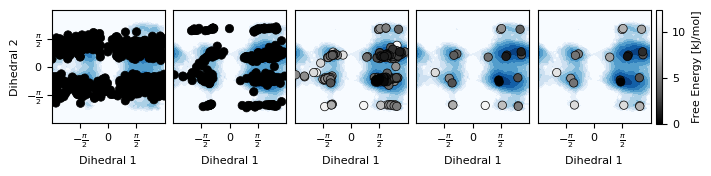

In [ ]:
import mdtraj
fig,axd = plt.subplot_mosaic([["DG","Minimized","Minimizeden","Minimizedens","Entropy"]],figsize=(7,3),constrained_layout=True)

ref_traj = mdtraj.load("example_xtc_C1_water.xtc",top=minimized_traj.top)
energies = out[2]
energies = energies - np.min(energies)

# get_xyz_and_plot(axd['DG'],ref_traj,0,15,0,10,legend=False)
plot_minimized_pos_and_energies(axd['DG'],unoptimized_traj,energies,0,np.inf,zorder=10)
plot_minimized_pos_and_energies(axd['Minimized'],minimized_traj,energies,0,np.inf,zorder=10)
plot_minimized_pos_and_energies(axd['Minimizeden'],minimized_traj,energies,0,5*kbt,zorder=10)
plot_minimized_pos_and_energies(axd['Minimizedens'],selected_traj,selected_energy,0,5*kbt,zorder=10)
plot_minimized_pos_and_energies(axd['Entropy'],selected_traj,entropy_out[1],0,5*kbt,zorder=10)

for ax in axd.values():
    get_xyz_and_plot(ax,ref_traj,0,5*kbt,0,10,legend=False)
    ax.set_xlabel("Dihedral 1")
    ax.set_ylabel("Dihedral 2")

    ax.set_xticks([np.pi/2,np.pi,np.pi/2+np.pi])
    ax.set_xticklabels([r"$-\frac{\pi}{2}$",r"0",r"$\frac{\pi}{2}$"])
    ax.set_yticks([np.pi/2,np.pi,np.pi/2+np.pi])
    ax.set_yticklabels([r"$-\frac{\pi}{2}$",r"0",r"$\frac{\pi}{2}$"])
    ax.axis('square')

    ax.set_xlim([0,2*np.pi])
    ax.set_ylim([0,2*np.pi])
    ax.get_yaxis().set_visible(False)
    
axd["DG"].get_yaxis().set_visible(True)

# make colorbar using Greys_r colormap from 0 to 5 kbt
norm = plt.Normalize(0,5*kbt)
sm = plt.cm.ScalarMappable(cmap="Greys_r", norm=norm)
sm.set_array([])
plt.colorbar(sm,ax=axd["Entropy"],orientation="vertical",label="Free Energy [kJ/mol]",ticks=[0,5,10],shrink=0.39)

fig.savefig("/fileserver/pine/pine8/kpaul/multi_solvent_pub/manuscript/Plots/Example_minimization.pdf")